Add Bullpen to Model

    - In the last notebook we augmented our dataframe to include various features based on the starting pitcher's performance
    - Now we will add these features in to see how much improvement we get to our model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df=pd.read_csv('df_bp7.csv', low_memory=False)

BEGIN MODELING

In [3]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1970) & (df.season<=2010) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2011) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [4]:
df.shape

(115999, 611)

In [5]:
hv_mean = df_train.home_victory.mean()

In [6]:
np.array(df.columns)

array(['date', 'dblheader_code', 'day_of_week', 'team_v', 'league_v',
       'game_no_v', 'team_h', 'league_h', 'game_no_h', 'runs_v', 'runs_h',
       'outs_total', 'day_night', 'completion_info', 'forfeit_info',
       'protest_info', 'ballpark_id', 'attendance', 'game_minutes',
       'linescore_v', 'linescore_h', 'AB_v', 'H_v', '2B_v', '3B_v',
       'HR_v', 'RBI_v', 'SH_v', 'SF_v', 'HBP_v', 'BB_v', 'IBB_v', 'SO_v',
       'SB_v', 'CS_v', 'GIDP_v', 'CI_v', 'LOB_v', 'P_num_v', 'ERind_v',
       'ERteam_v', 'WP_v', 'balk_v', 'PO_v', 'ASST_v', 'ERR_v', 'PB_v',
       'DP_v', 'TP_v', 'AB_h', 'H_h', '2B_h', '3B_h', 'HR_h', 'RBI_h',
       'SH_h', 'SF_h', 'HBP_h', 'BB_h', 'IBB_h', 'SO_h', 'SB_h', 'CS_h',
       'GIDP_h', 'CI_h', 'LOB_h', 'P_num_h', 'ERind_h', 'ERteam_h',
       'WP_h', 'balk_h', 'PO_h', 'ASST_h', 'ERR_h', 'PB_h', 'DP_h',
       'TP_h', 'ump_HB_id', 'ump_HB_name', 'ump_1B_id', 'ump_1B_name',
       'ump_2B_id', 'ump_2B_name', 'ump_3B_id', 'ump_3B_name',
       'ump_LF_id'

Let's add in some basic bullpen features

In [7]:
target = 'home_victory'

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [8]:
def try_features(feat_set, max_depth=2):
    target = 'home_victory'
    X_train = df_train.loc[:,feat_set]
    X_valid = df_valid.loc[:,feat_set]
    X_test = df_test.loc[:,feat_set]



    lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=max_depth)
    lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50)])
    
    preds_lgbm_test = lgbm1.predict_proba(X_test)[:,1]
    ll_test = log_loss(y_test, preds_lgbm_test)

    print(f'\nVegas probs: {log_loss(y_test,df_test.implied_prob_h_mid)} on test')
    print(f'model probs: {ll_test} on test')

    print(f'\nDifference: {ll_test - log_loss(y_test,df_test.implied_prob_h_mid)} on test')

    sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
    sv_lgbm = pd.DataFrame(sv_lgbm)
    sv_lgbm.columns = list(X_test.columns)+['Intercept']
    sv_vec = sv_lgbm.abs().mean().sort_values(ascending=False)
    print('\nAvg Shap Vals')
    
    print(sv_vec)
    out_dict={}
    out_dict['ll_test'] = ll_test
    out_dict['model'] = lgbm1
    out_dict['shap_val_avgs'] = sv_vec
    out_dict['preds_test'] = preds_lgbm_test
    return(out_dict)

In [9]:
features1 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            ]

In [10]:
d1 = try_features(features1)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[641]	valid_0's binary_logloss: 0.681268

Vegas probs: 0.6675629431340582 on test
model probs: 0.6749157719382763 on test

Difference: 0.00735282880421817 on test

Avg Shap Vals
Intercept               0.165681
Strt_SO_perc_10_v       0.098728
Strt_SO_perc_10_h       0.095822
OBP_162_h               0.082925
Strt_WHIP_35_v          0.079416
OBP_162_v               0.078107
Strt_WHIP_35_h          0.067631
SLG_162_h               0.051763
SLG_162_v               0.047923
Strt_TB_BB_perc_35_h    0.039821
Strt_TB_BB_perc_35_v    0.027293
Strt_H_BB_perc_35_h     0.026723
Strt_H_BB_perc_35_v     0.019778
dtype: float64


In [11]:
features2 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            ]

In [12]:
d2 = try_features(features2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[764]	valid_0's binary_logloss: 0.679954

Vegas probs: 0.6675629431340582 on test
model probs: 0.6729201647511844 on test

Difference: 0.005357221617126262 on test

Avg Shap Vals
Intercept               0.165862
Strt_SO_perc_10_v       0.102896
Strt_SO_perc_10_h       0.093368
OBP_162_h               0.079285
Strt_WHIP_35_v          0.077666
OBP_162_v               0.066830
Strt_WHIP_35_h          0.061414
SLG_162_v               0.050161
SLG_162_h               0.046989
Strt_TB_BB_perc_35_h    0.038087
Bpen_H_BB_perc_35_v     0.030019
Bpen_SO_perc_35_v       0.029983
Strt_H_BB_perc_35_h     0.024942
Bpen_SO_perc_35_h       0.024066
Strt_TB_BB_perc_35_v    0.022483
Bpen_TB_BB_perc_35_v    0.022425
Bpen_H_BB_perc_35_h     0.021623
Strt_H_BB_perc_35_v     0.017670
Bpen_TB_BB_perc_35_h    0.008785
Bpen_WHIP_35_v          0.003612
Bpen_WHIP_35_h          0.003541
dtype: float64


In [13]:
features3 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
            ]

In [14]:
d3 = try_features(features3, max_depth=2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[757]	valid_0's binary_logloss: 0.679964

Vegas probs: 0.6675629431340582 on test
model probs: 0.6725728571502665 on test

Difference: 0.005009914016208317 on test

Avg Shap Vals
Intercept               0.165887
Strt_SO_perc_10_v       0.096716
Strt_SO_perc_10_h       0.082694
Strt_WHIP_35_v          0.077060
OBP_162_h               0.073450
OBP_162_v               0.065831
Strt_WHIP_35_h          0.059847
SLG_162_v               0.044387
SLG_162_h               0.043014
Bpen_SO_perc_75_v       0.038986
Strt_TB_BB_perc_35_h    0.036014
Strt_H_BB_perc_35_h     0.022195
Bpen_H_BB_perc_35_v     0.021925
Strt_TB_BB_perc_35_v    0.020107
Bpen_TB_BB_perc_10_v    0.020019
Strt_H_BB_perc_35_v     0.017077
Bpen_H_BB_perc_75_h     0.016834
Bpen_SO_perc_75_h       0.015985
Bpen_TB_BB_perc_75_h    0.014104
Bpen_WHIP_10_v          0.011740
Bpen_H_BB_perc_35_h     0.010185
Bpen_TB_BB_perc_75_v    0.009282

In [15]:
features4 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_75_h','Strt_WHIP_75_v',
            'Strt_TB_BB_perc_75_h', 'Strt_TB_BB_perc_75_v',
            'Strt_H_BB_perc_75_h', 'Strt_H_BB_perc_75_v',
            'Strt_SO_perc_75_h', 'Strt_SO_perc_75_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_WHIP_10_h','Strt_WHIP_10_v',
            'Strt_TB_BB_perc_10_h', 'Strt_TB_BB_perc_10_v',
            'Strt_H_BB_perc_10_h', 'Strt_H_BB_perc_10_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
            ]

In [16]:
d4 = try_features(features4)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[728]	valid_0's binary_logloss: 0.679791

Vegas probs: 0.6675629431340582 on test
model probs: 0.6723795629726537 on test

Difference: 0.004816619838595493 on test

Avg Shap Vals
Intercept               0.165979
Strt_SO_perc_10_v       0.082403
OBP_162_h               0.067962
OBP_162_v               0.066108
Strt_SO_perc_10_h       0.065007
Strt_WHIP_75_v          0.054843
SLG_162_v               0.042117
SLG_162_h               0.041784
Strt_H_BB_perc_75_h     0.039027
Bpen_SO_perc_75_v       0.036275
Strt_WHIP_35_v          0.033182
Strt_TB_BB_perc_35_h    0.030875
Strt_WHIP_35_h          0.029577
Strt_WHIP_75_h          0.025244
Bpen_H_BB_perc_35_v     0.021022
Bpen_TB_BB_perc_10_v    0.019043
Bpen_H_BB_perc_75_h     0.015137
Strt_TB_BB_perc_35_v    0.014539
Bpen_WHIP_10_v          0.013020
Bpen_TB_BB_perc_75_h    0.012310
Bpen_SO_perc_75_h       0.011536
Strt_TB_BB_perc_10_h    0.008420

In [17]:
features5 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
             'ERR_162_h', 'ERR_162_v',
             'SB_162_h', 'SB_162_v',
             'CS_162_h', 'CS_162_v',
             
             
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
            ]

In [18]:
d5 = try_features(features5)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[787]	valid_0's binary_logloss: 0.679926

Vegas probs: 0.6675629431340582 on test
model probs: 0.6728450802135807 on test

Difference: 0.00528213707952252 on test

Avg Shap Vals
Intercept               0.165923
Strt_SO_perc_10_v       0.096898
Strt_SO_perc_10_h       0.087142
Strt_WHIP_35_v          0.076351
OBP_162_h               0.069614
OBP_162_v               0.058667
Strt_WHIP_35_h          0.057649
SLG_162_v               0.042694
SLG_162_h               0.041899
Strt_TB_BB_perc_35_h    0.034993
Bpen_SO_perc_75_v       0.032448
Strt_H_BB_perc_35_h     0.023087
Bpen_H_BB_perc_35_v     0.020972
SB_162_v                0.020952
Strt_TB_BB_perc_35_v    0.019989
ERR_162_h               0.017709
Strt_H_BB_perc_35_v     0.015533
SB_162_h                0.015291
ERR_162_v               0.015219
Bpen_TB_BB_perc_75_h    0.014774
Bpen_H_BB_perc_75_h     0.014322
Bpen_SO_perc_75_h       0.013937


In [19]:
rd = mli.get_range_dict(df_train)
plot_pts = df_test.loc[:,features5].sample(1, random_state=42)

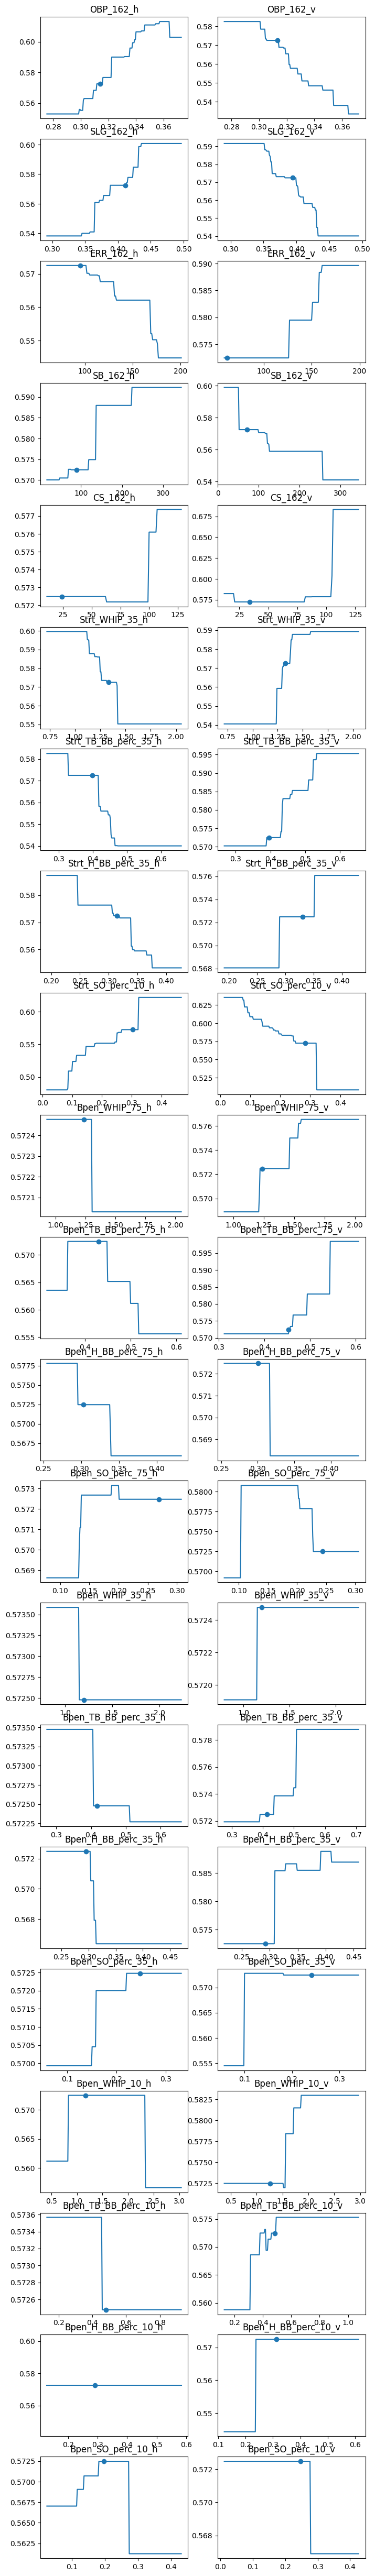

In [20]:
mli.ice_plot(d5['model'], plot_pts, features5, rd, plots_per_row=2)

In [21]:
df['SBadj_162_h'] = df['SB_162_h'] - 3*df['CS_162_h']
df['SBadj_162_v'] = df['SB_162_v'] - 3*df['CS_162_v']

In [22]:
df_train = df[(df.season>1970) & (df.season<=2010) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2011) & (df.season<=2020)]
df_test = df[df.season>=2021]
df_test_val = df[df.season>=2019]

In [23]:
len(df.OBP_162_h)

115999

In [24]:
features6  = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
             'ERR_162_h', 'ERR_162_v',
             # 'SB_162_h', 'SB_162_v',
             # 'CS_162_h', 'CS_162_v',
             'SBadj_162_h','SBadj_162_v',
             
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v',
            ]


In [25]:
d6 = try_features(features6)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[768]	valid_0's binary_logloss: 0.680048

Vegas probs: 0.6675629431340582 on test
model probs: 0.6728200439286236 on test

Difference: 0.005257100794565428 on test

Avg Shap Vals
Intercept               0.165874
Strt_SO_perc_10_v       0.095560
Strt_SO_perc_10_h       0.079552
Strt_WHIP_35_v          0.076325
OBP_162_h               0.064819
OBP_162_v               0.060050
Strt_WHIP_35_h          0.058889
SLG_162_h               0.040412
SLG_162_v               0.038113
Strt_TB_BB_perc_35_h    0.034411
Bpen_SO_perc_75_v       0.033049
SBadj_162_h             0.023207
Strt_H_BB_perc_35_h     0.022436
Bpen_H_BB_perc_35_v     0.021317
SBadj_162_v             0.021115
Strt_TB_BB_perc_35_v    0.019377
Bpen_SO_perc_75_h       0.016560
Bpen_TB_BB_perc_10_v    0.016473
Strt_H_BB_perc_35_v     0.015521
Bpen_TB_BB_perc_75_h    0.015151
ERR_162_v               0.013693
Bpen_WHIP_10_v          0.013301

In [26]:

len(features6)

40

Let's analyze model 4

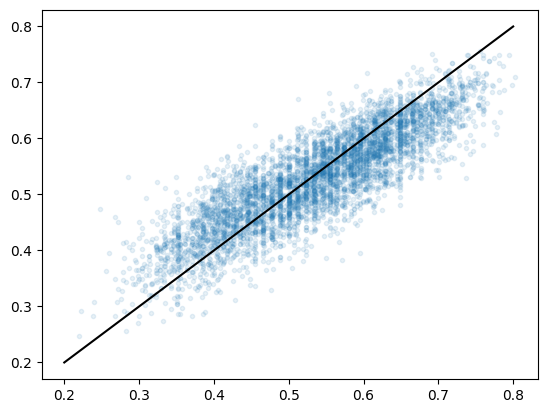

In [27]:
plt.scatter(df_test.implied_prob_h_mid, d4['preds_test'], marker='.', alpha=.1)
plt.plot([.2,.8],[.2,.8], color='k')

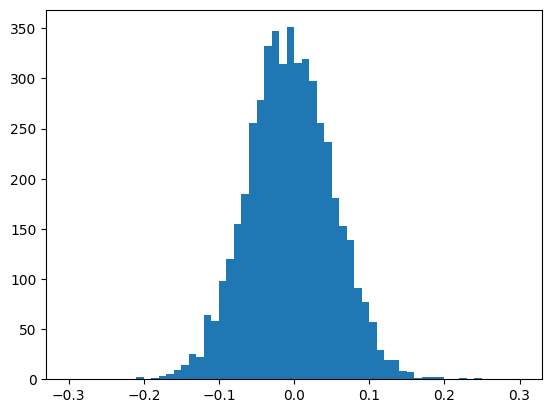

In [28]:
test_disc = d4['preds_test'] - df_test.implied_prob_h_mid
plt.hist(test_disc, bins=np.linspace(-.3,.3,61));

In [29]:
## let's compare performance on the cases with a large discrepancy
mask = (np.abs(test_disc))>.1
log_loss(y_test[mask], d4['preds_test'][mask]), log_loss(y_test[mask], df_test.implied_prob_h_mid[mask])

(0.672695926249748, 0.6367003673962248)

In [30]:
log_loss(y_test[~mask], d4['preds_test'][~mask]), log_loss(y_test[~mask], df_test.implied_prob_h_mid[~mask])

(0.6723548921194521, 0.6699696892091481)

Conclusions
    - Still about 40 bps away from Vegas probabilities (down from ~70)
    - When our model and Vegas "disagree", Vegas is generally right!

    - We are running out of "big wins"
    - Features based on actual starting lineup
    - Fielding
    - Lefty vs Righty analysis

Next Steps

    - Get individual batter data
    - Make features based on the actual lineup
    - Analyze runs scored (over/under)
    - Perhaps the model for runs scored will help with the moneyline model